In [1]:
# Imports and setup
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/style_transfer/")
from network_builder import *
import skimage as sk
import skimage.io as skio
from torch.optim import LBFGS
import torch
from matplotlib import pyplot as plt
import numpy as np
from torchvision.models import vgg19,VGG19_Weights
from PIL.Image import open as load_image
%load_ext autoreload
%autoreload 2
# Which device is available?
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'

Mounted at /content/drive/


In [54]:
# dimensions of square input image
im_size=512
# Switch max_pool for avg_pool
avg_pool=True

# Input images
content = 'sd'
style = 'starry-night'
# Weights should come from the VGG19 model. No further training necessary
# we only want the 'features' portion of the VGG-19 model
vgg_model=vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features
vgg_model.to(device)
vgg_model.eval()

# Normalization mean and standard deviation, used in first layer of model
# Values taken from pytorch vgg19 webpage and are the normalization constants from the
# original model
mean=torch.tensor([0.485,0.456,0.406])
std=torch.tensor([0.229,0.224,0.225])
mean.to(device)
std.to(device)

# Weights for style and content
w_style=1e6
w_content=1e0

# Import photos using SK Image into tensors
im_content=load_image(im_dir+in_dir+content+'.jpg')
im_style=load_image(im_dir+in_dir+style+'.jpg')
# Preprocess
im_content=preprocess(im_size)(im_content).unsqueeze(0).float().to(device)
im_style=preprocess(im_size)(im_style).unsqueeze(0).float().to(device)
im_target=im_content.clone()

# Using L-BFGS optimizer, aka gradient descent in first and second derivative
optimizer=LBFGS([im_target.requires_grad_()])

# At which layers do we want to calculate style loss and content loss? Taken from paper
style_layers=[1,2,3,4,5]
content_layers=[4]

content_loss_over_time=[]
style_loss_over_time=[]
# Set up modified model
model,style_layers,content_layers=build_cnn(device,vgg_model,
                                            mean,std,
                                            im_style,im_content,
                                            style_layers,content_layers,avg_pool
                                            )
n_epochs=100  # must be multiple of 20

Epoch 20 Complete.
Content Loss: 1.947984 Style Loss: 0.466938
Epoch 40 Complete.
Content Loss: 1.172207 Style Loss: 0.203497
Epoch 60 Complete.
Content Loss: 1.061034 Style Loss: 0.115363
Epoch 80 Complete.
Content Loss: 1.024452 Style Loss: 0.096066


Epoch 100 Complete.
Content Loss: 1.008380 Style Loss: 0.094765


Text(0.5, 1.0, 'Loss over time for generated image')

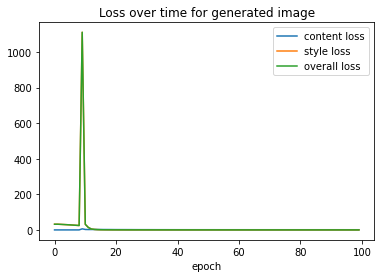

In [55]:
while len(content_loss_over_time)<n_epochs:
    # Closure loop for L-BFGS
    def closure():
        # Clip input image and run modified model on it
        im_target.data.clamp_(0,1)
        optimizer.zero_grad()
        model(im_target)
        # Calculate weighted loss of new image
        style_loss=0
        content_loss=0

        for layer in style_layers:
            style_loss+=layer.loss

        for layer in content_layers:
            content_loss+=layer.loss

        content_loss_over_time.append(content_loss.item())
        style_loss_over_time.append(style_loss.item())

        loss=style_loss*w_style+content_loss*w_content
        loss.backward()
        if len(content_loss_over_time)%20==0:
            print("Epoch {} Complete.".format(len(content_loss_over_time)))
            print("Content Loss: {:4f} Style Loss: {:4f}".format(
                content_loss.item() * w_content,
                style_loss.item() * w_style
            ))
        return loss

    optimizer.step(closure)

# Clip to 0-1, save image
im_target.data.clamp_(0,1)
skio.imsave(im_dir+out_dir+content+'_'+style+'.jpg',sk.img_as_uint(im_target.detach().cpu().squeeze(0).permute(1,2,0)))

# Plot loss
cl=np.array(content_loss_over_time) * w_content
sl=np.array(style_loss_over_time) * w_style
plt.plot(cl)
plt.plot(sl)
plt.plot((cl*w_content+sl*w_style)/(w_content+w_style))
plt.legend(['content loss','style loss','overall loss'])
plt.xlabel('epoch')
plt.title("Loss over time for generated image")
plt.savefig(im_dir+out_dir+"{}_{}_loss.jpg".format(content,style))

In [26]:
print(vgg_model[4])

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [31]:
torch.nn.AvgPool2d(kernel_size=2)

AvgPool2d(kernel_size=2, stride=2, padding=0)